In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd

In [24]:
def load_data(picNums):
    os.chdir('..')
    df = pd.read_csv('negs.csv')
    os.chdir('films')
    lst = []
    for i in range(picNums):
        img = cv.imread(str(i+1)+".jpeg")
        lst.append(img)
    df['pictures']=lst
    os.chdir('..')
    return df

In [25]:
total = 494
df = load_data(total)
print(df)

      picture  normal                                           pictures
0      1.jpeg       0  [[[16, 38, 79], [16, 38, 79], [15, 37, 78], [1...
1      2.jpeg       1  [[[0, 34, 87], [0, 37, 90], [0, 40, 93], [0, 4...
2      3.jpeg       0  [[[47, 42, 63], [47, 42, 63], [47, 42, 63], [4...
3      4.jpeg       1  [[[58, 67, 101], [58, 67, 101], [57, 66, 100],...
4      5.jpeg       0  [[[70, 77, 97], [70, 77, 97], [70, 77, 97], [7...
..        ...     ...                                                ...
489  490.jpeg       1  [[[1, 31, 58], [3, 33, 60], [7, 37, 64], [11, ...
490  491.jpeg       1  [[[15, 36, 67], [16, 37, 68], [17, 38, 69], [1...
491  492.jpeg       1  [[[64, 121, 166], [57, 114, 159], [51, 106, 15...
492  493.jpeg       1  [[[6, 46, 75], [8, 48, 77], [11, 51, 80], [13,...
493  494.jpeg       1  [[[14, 68, 103], [16, 70, 105], [18, 72, 105],...

[494 rows x 3 columns]


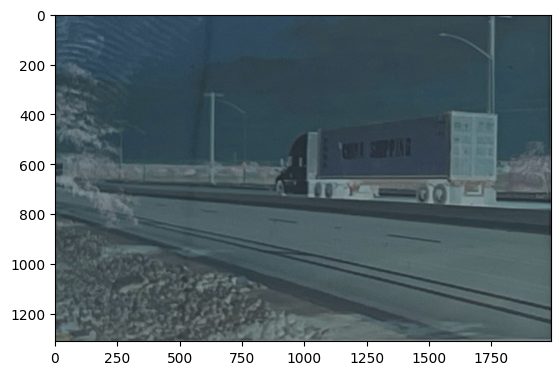

In [26]:
plt.imshow(df['pictures'][472])

In [27]:
normal = sum([1 for i in df['normal'] if i == 1])
normal

360

In [28]:
abnormal_rate = sum([1 for i in df['normal'] if i == 0]) / 421
abnormal_rate

0.3182897862232779

In [29]:
from torchvision import transforms
from PIL import Image

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [30]:
# https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=train_transform, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, idx

In [31]:
dataset = CustomImageDataset('negs.csv','/Users/patrickdeng/Documents/film project/films')

In [32]:
dataset[472]

(tensor([[[-0.2856, -0.2342, -0.2856,  ..., -0.7822, -0.8678, -0.2856],
          [-0.4739, -0.3712, -0.3541,  ..., -0.7650, -0.8678, -0.2513],
          [-0.5424, -0.3883, -0.3883,  ..., -0.7650, -0.8678, -0.2342],
          ...,
          [-0.5767, -0.6281, -0.6109,  ..., -0.5253, -0.5424, -0.5596],
          [-0.4568, -0.4397, -0.4226,  ..., -0.3541, -0.3712, -0.1999],
          [-0.3027, -0.2684, -0.2513,  ...,  0.2967,  0.2624,  0.2624]],
 
         [[-0.4426, -0.4426, -0.4776,  ..., -0.7752, -0.8627, -0.2150],
          [-0.6352, -0.5826, -0.5301,  ..., -0.7752, -0.8627, -0.1975],
          [-0.7052, -0.5826, -0.5651,  ..., -0.7752, -0.8627, -0.1975],
          ...,
          [-0.3200, -0.3725, -0.3550,  ..., -0.4251, -0.4426, -0.4426],
          [-0.2150, -0.1800, -0.1625,  ..., -0.2675, -0.2850, -0.0574],
          [-0.0924, -0.0574, -0.0399,  ...,  0.3452,  0.3102,  0.3627]],
 
         [[-0.6541, -0.6367, -0.6715,  ..., -0.8633, -0.9156, -0.2358],
          [-0.8633, -0.7936,

In [33]:
dataset.__len__()

494

In [34]:
from torch.utils.data import DataLoader, random_split, Subset

val_size, train_size = total // 4, total - total // 4
training_data, test_data = random_split(dataset, [train_size, val_size])

train_ds = Subset(CustomImageDataset('negs.csv','/Users/patrickdeng/Documents/film project/films',transform=train_transform), training_data.indices)
test_ds = Subset(CustomImageDataset('negs.csv','/Users/patrickdeng/Documents/film project/films',transform=test_transform), test_data.indices)

BATCH_SIZE = 36

training_data = DataLoader(training_data,batch_size=BATCH_SIZE,shuffle=True)
test_data = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)


In [35]:
training_data.__len__()

11

In [36]:
test_data.__len__()

4

In [37]:
import torch.nn.functional as F

In [38]:
class ResBlk(nn.Module):
    def __init__(self,numChannels,kernel=3,stride=1,padding=1,bypass=True):
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels=numChannels,kernel_size=kernel,stride=stride,padding=padding,bias=False)
        self.conv2 = nn.LazyConv2d(out_channels=numChannels,kernel_size=kernel,stride=1,padding=1,bias=False)
        self.conv3 = nn.Identity()
        if bypass:
            self.conv3 = nn.Sequential(
                nn.LazyConv2d(out_channels=numChannels,kernel_size=1,stride=stride,bias=False),
                nn.LazyBatchNorm2d()
            )
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [39]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.LazyLinear(1)
        self.model = nn.Sequential(
            nn.LazyConv2d(out_channels=64,kernel_size=7,stride=2,padding=1,bias=False),
            nn.LazyBatchNorm2d(),
            nn.MaxPool2d(kernel_size=3),
            ResBlk(numChannels=64,kernel=3,bypass=False),
            ResBlk(numChannels=64,kernel=3,bypass=False),
            ResBlk(numChannels=128,kernel=3,bypass=True),
            ResBlk(numChannels=128,kernel=3,bypass=False),
            ResBlk(numChannels=256,kernel=3,bypass=True),
            ResBlk(numChannels=256,kernel=3,bypass=False),
            ResBlk(numChannels=512,kernel=3,bypass=True),
            ResBlk(numChannels=512,kernel=3,bypass=False),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self,X):
        return self.fc(self.model(X).flatten(1))

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
EPOCHES = 10
model = ResNet18()
LR = 3e-4
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer,patience=2,factor=0.5,eps=1e-6)
#scheduler = CosineAnnealingLR(optimizer, T_max = EPOCHES)
from sklearn.metrics import f1_score

In [41]:
def test(epoches,LR,optimizer,scheduler):
    neg = abnormal_rate
    pos = 1 - neg
    accu = []
    train_loss_set = []
    val_loss_set = []
    lr_set = []
    f1score = []
    criterion = BCEWithLogitsLoss()
    for epoch in range(epoches):
        lr = optimizer.param_groups[0]['lr']
        lr_set.append(lr)
        model.train()
        train_loss = 0
        for (images, labels, index) in training_data:
            labels = labels.float().unsqueeze(1)
            logits = model(images)
            loss = criterion(logits, labels.float())
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss_set.append(train_loss / len(training_data))
        model.eval()
        with torch.no_grad():
            total, correct = 0,0
            all_labels = []
            all_preds = []
            val_loss = 0
            f1 = 0
            for (images, labels, index) in test_data:
                outputs = model(images)
                probs = F.sigmoid(outputs)
                preds = (probs >= 0.5).float().view(-1)
                labels = labels.long().view(-1)
                val_loss += criterion(outputs, labels.float().unsqueeze(1))
                total += len(labels)
                correct += sum(preds == labels)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                f1 += f1_score(labels,preds)
            average_val_loss = val_loss / len(test_data)
            val_loss_set.append(average_val_loss)
            average_f1 = f1 / len(test_data)
            f1score.append(average_f1)
            scheduler.step(average_val_loss)
            #scheduler.step()
            acc = correct / total
            accu += [acc]
            print(f"epoch: {epoch+1}, accuracy rate: {(acc*100):.3f}%, train loss: {train_loss_set[-1]:.3f}, val loss: {val_loss_set[-1]:.3f}, learning rate: {lr:.7f}, f1 score: {average_f1:.3f}")
            if (epoch + 1) % 2 == 0:
                print("Confusion matrix")
                ConfusionMatrixDisplay.from_predictions(all_labels,all_preds)
                plt.show()
    return accu, train_loss_set, val_loss_set, lr_set, f1score

epoch: 1, accuracy rate: 73.984%, train loss: 0.707, val loss: 0.641, learning rate: 0.0003000, f1 score: 0.850
epoch: 2, accuracy rate: 62.602%, train loss: 0.552, val loss: 0.713, learning rate: 0.0003000, f1 score: 0.682
Confusion matrix


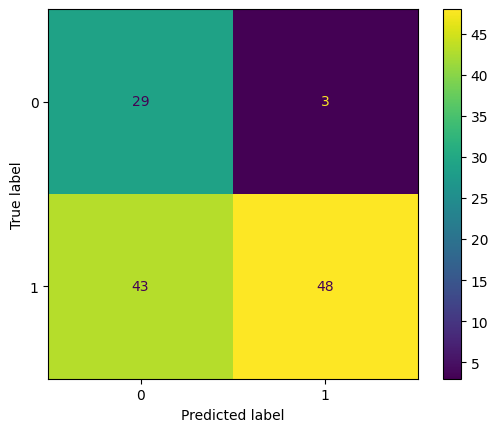

epoch: 3, accuracy rate: 74.797%, train loss: 0.455, val loss: 0.511, learning rate: 0.0003000, f1 score: 0.800
epoch: 4, accuracy rate: 77.236%, train loss: 0.434, val loss: 0.505, learning rate: 0.0003000, f1 score: 0.816
Confusion matrix


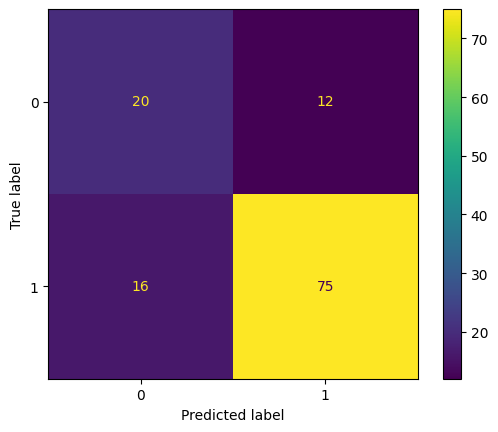

epoch: 5, accuracy rate: 73.171%, train loss: 0.443, val loss: 0.517, learning rate: 0.0003000, f1 score: 0.814
epoch: 6, accuracy rate: 78.862%, train loss: 0.428, val loss: 0.506, learning rate: 0.0003000, f1 score: 0.856
Confusion matrix


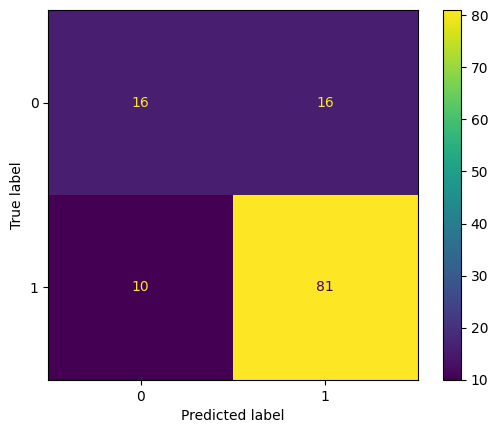

epoch: 7, accuracy rate: 75.610%, train loss: 0.426, val loss: 0.462, learning rate: 0.0003000, f1 score: 0.838
epoch: 8, accuracy rate: 80.488%, train loss: 0.416, val loss: 0.439, learning rate: 0.0003000, f1 score: 0.886
Confusion matrix


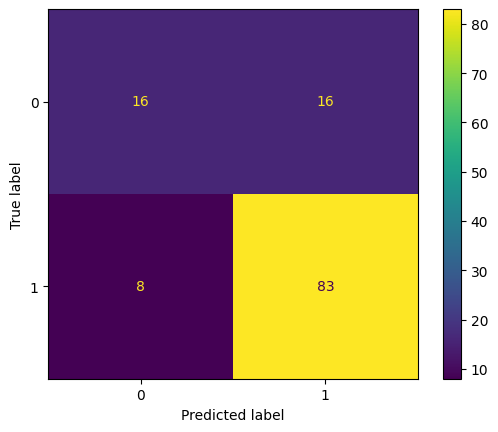

epoch: 9, accuracy rate: 82.927%, train loss: 0.409, val loss: 0.412, learning rate: 0.0003000, f1 score: 0.898
epoch: 10, accuracy rate: 82.927%, train loss: 0.373, val loss: 0.465, learning rate: 0.0003000, f1 score: 0.894
Confusion matrix


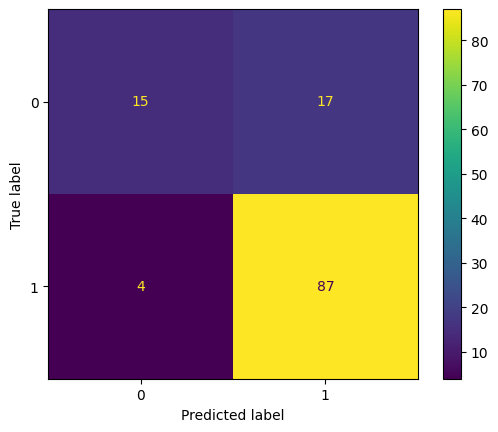

In [42]:
accu, train_loss, val_loss, lrs, f1score = test(EPOCHES,LR,optimizer,scheduler)

In [43]:
print(len(accu))
print(len(train_loss))
print(len(val_loss))
print(len(lrs))
print(len(f1score))

10
10
10
10
10


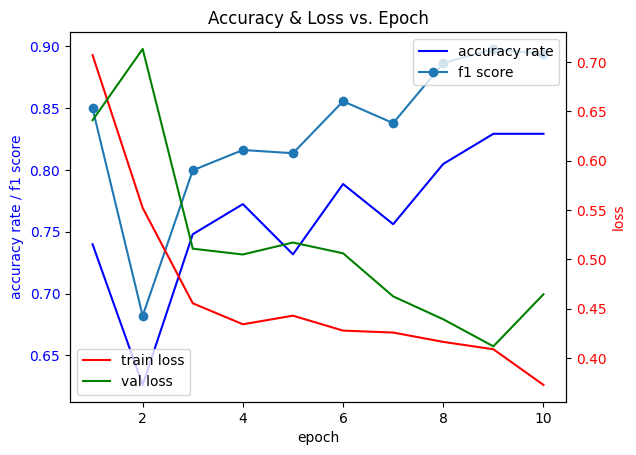

In [86]:
fig, ax1 = plt.subplots()

ax1.plot(range(1,EPOCHES+1), accu, 'b-', label='accuracy rate')
ax1.plot(range(1,EPOCHES+1), f1score, 'o-', label='f1 score')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy rate / f1 score',color='b')
ax1.tick_params(axis='y',labelcolor='b')


ax2 = ax1.twinx()
ax2.plot(range(1,EPOCHES+1), [i.detach().numpy() for i in train_loss], 'r-',label='train loss')
ax2.plot(range(1,EPOCHES+1), [i.detach().numpy() for i in val_loss], 'g-',label='val loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss', color='r')
ax2.tick_params(axis='y',labelcolor='r')


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(loc='upper right')

ax2.legend(loc='lower left')
plt.title('Accuracy & Loss vs. Epoch')
plt.show()

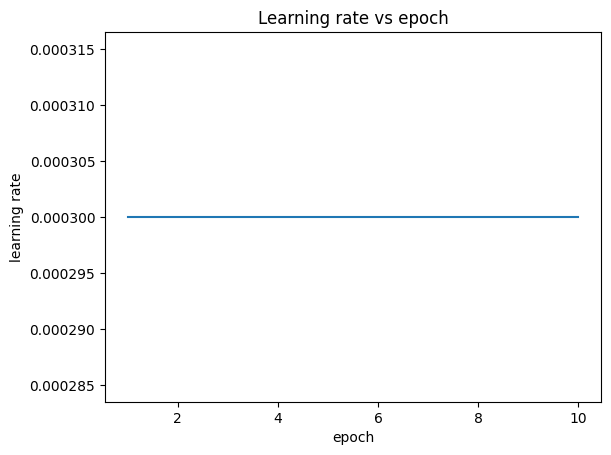

In [87]:
plt.plot(range(1,EPOCHES+1), lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("Learning rate vs epoch")
plt.show()

In [69]:
def wrong_results(model, dataset):
    model.eval()
    wrong_images = []
    wrong_labels = []
    wrong_preds = []
    y_preds = []
    y_labels = []
    with torch.no_grad():
        for (images, labels, indices) in test_data:
            outputs = model(images)
            probs = F.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            y_preds.extend(preds)
            y_labels.extend(labels)
            wrongidx = [indices[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]]
            wrong_labels.extend([labels[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]])
            wrong_preds.extend([preds[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]])

            for idx in wrongidx:
                wrong_images.append(df['pictures'][idx.numpy().item()])
        batchsize = 36
        print(f'mistakes: {len(wrong_preds)} out of {test_data.__len__() * batchsize}')
        accuracy = accuracy_score(y_labels,y_preds)
        f1 = f1_score(y_labels,y_preds)
        precision = precision_score(y_labels,y_preds)
        recall = recall_score(y_labels,y_preds)
        print(f'accuracy rate: {accuracy * 100 :.3f}%')
        print(f'f1 rate: {f1 * 100 :.3f}%')
        print(f'precision rate: {precision * 100 :.3f}%')
        print(f'recall rate: {recall * 100 :.3f}%')
        ConfusionMatrixDisplay.from_predictions(y_labels,y_preds)
        plt.show()
        return wrong_images, wrong_labels, wrong_preds
    

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def wrong_results(model, dataset):
    model.eval()
    wrong_images = []
    wrong_labels = []
    wrong_preds = []
    y_true = []
    y_preds = []
    with torch.no_grad():
        for (images, labels, indices) in test_data:
            outputs = model(images)
            probs = F.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            y_preds.extend(preds)
            y_true.extend(labels)
            wrongidx = [indices[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]]
            wrong_labels.extend([labels[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]])
            wrong_preds.extend([preds[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]])
            for idx in wrongidx:
                wrong_images.append(df['pictures'][idx.numpy().item()])
        BATCHSIZE = 36
        print(f'mistakes: {len(wrong_labels)} out of {len(y_preds)}')
        print(f'accuracy rate: {accuracy_score(y_true,y_preds)*100:.3f}%')
        print(f'f1 rate: {f1_score(y_true,y_preds)*100:.3f}%')
        print(f'precision rate: {precision_score(y_true,y_preds)*100:.3f}%')
        print(f'recall rate: {recall_score(y_true,y_preds)*100:.3f}%')
        ConfusionMatrixDisplay.from_predictions(np.array(y_true), np.array(y_preds))
        plt.show()
        return wrong_images, wrong_labels, wrong_preds

mistakes: 21 out of 123
accuracy rate: 82.927%
f1 rate: 89.231%
precision rate: 83.654%
recall rate: 95.604%


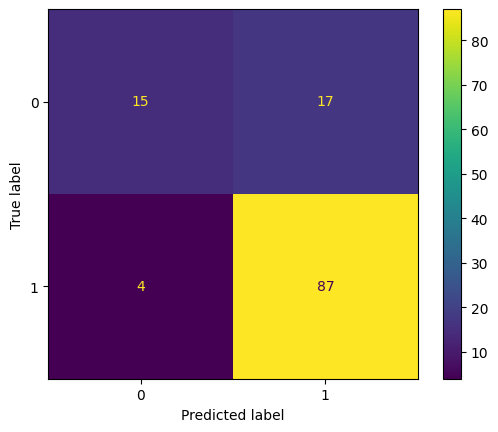

this image is abnormal but was predicted as normal


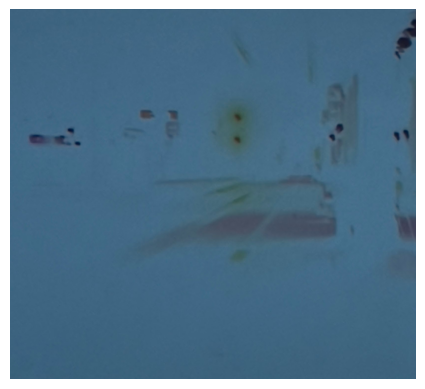

this image is abnormal but was predicted as normal


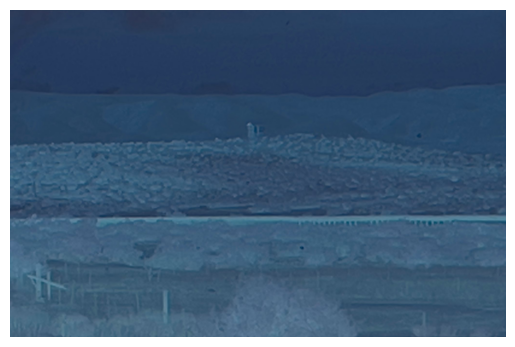

this image is abnormal but was predicted as normal


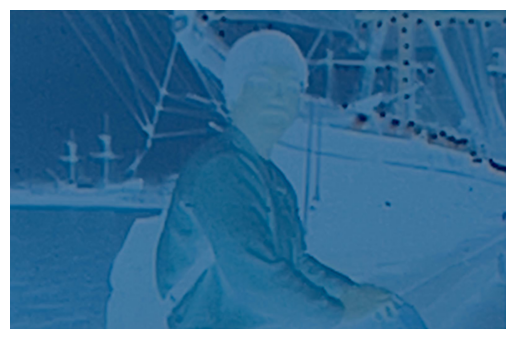

this image is abnormal but was predicted as normal


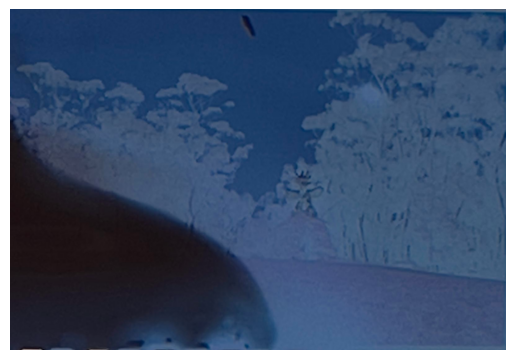

this image is abnormal but was predicted as normal


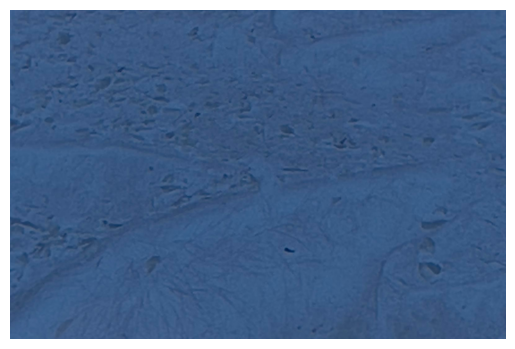

this image is abnormal but was predicted as normal


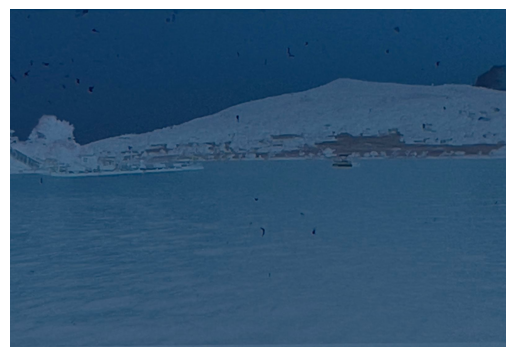

this image is abnormal but was predicted as normal


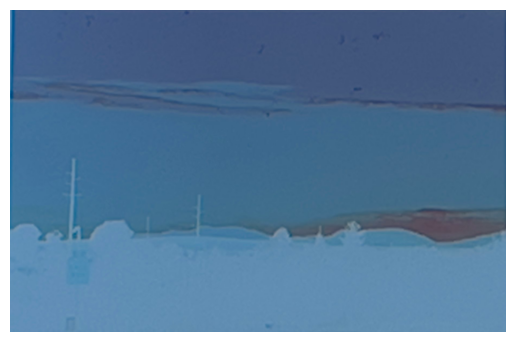

this image is abnormal but was predicted as normal


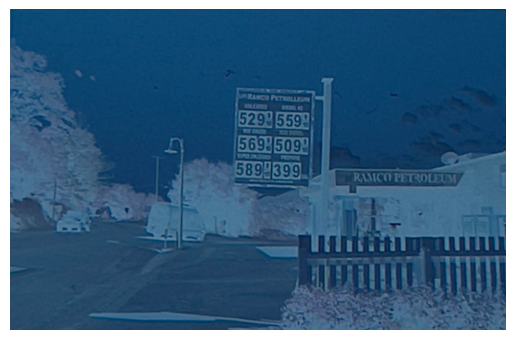

this image is abnormal but was predicted as normal


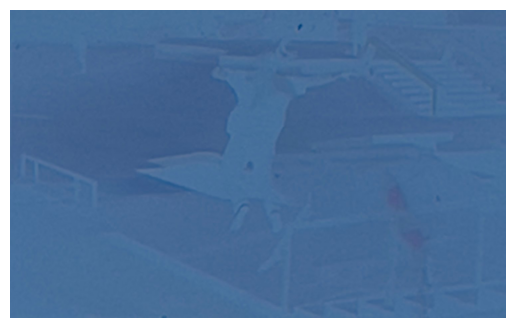

this image is abnormal but was predicted as normal


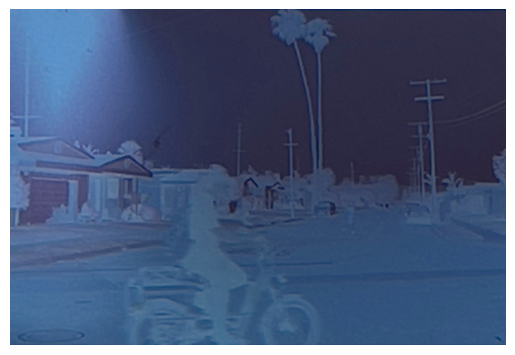

this image is normal but was predicted as abnormal


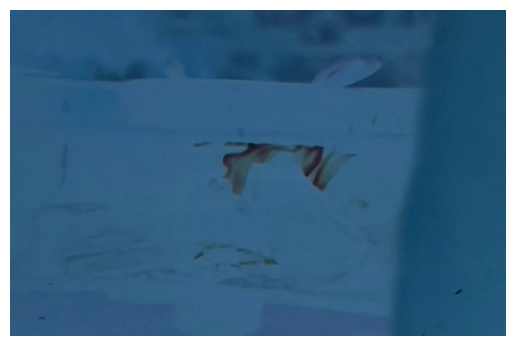

this image is abnormal but was predicted as normal


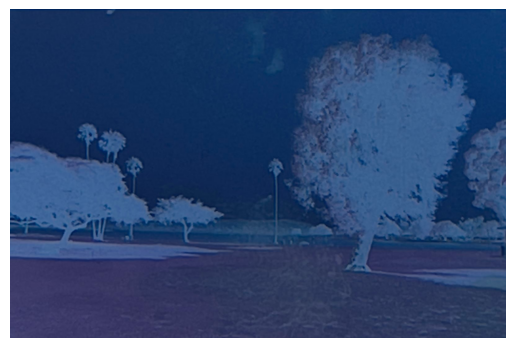

this image is normal but was predicted as abnormal


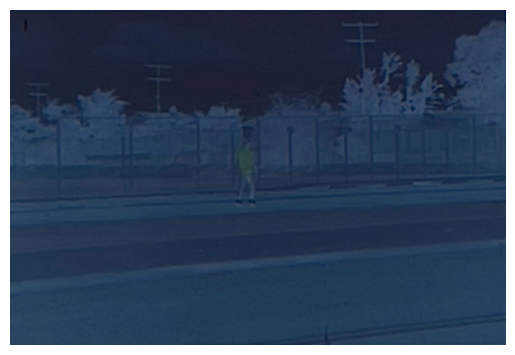

this image is abnormal but was predicted as normal


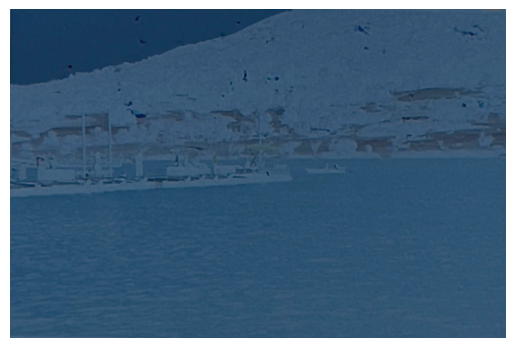

this image is normal but was predicted as abnormal


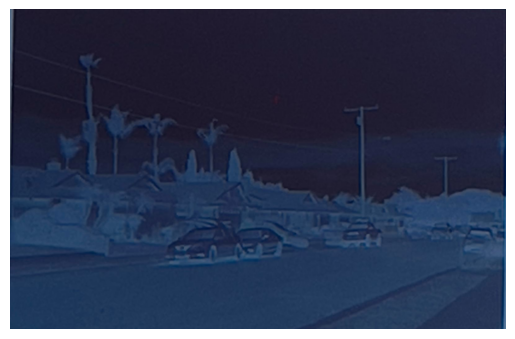

this image is abnormal but was predicted as normal


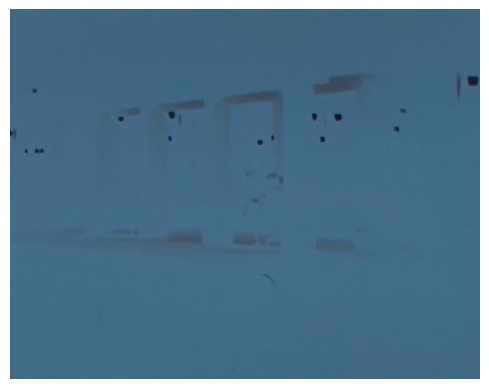

this image is abnormal but was predicted as normal


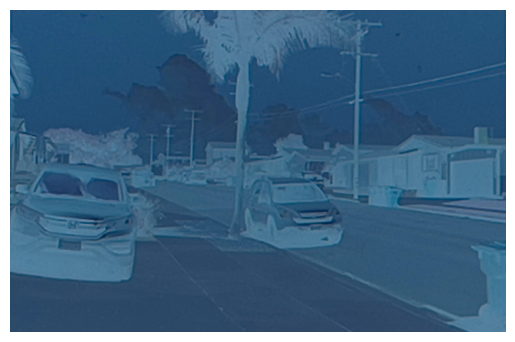

this image is abnormal but was predicted as normal


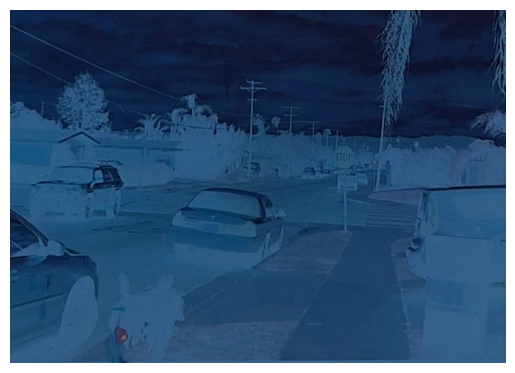

this image is normal but was predicted as abnormal


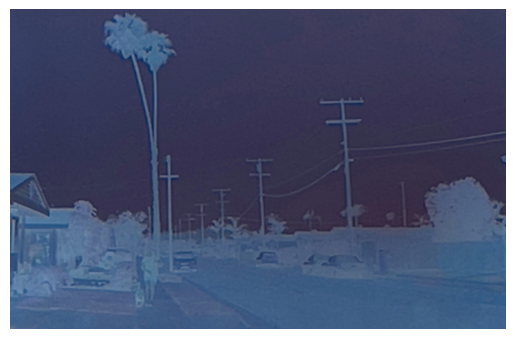

this image is abnormal but was predicted as normal


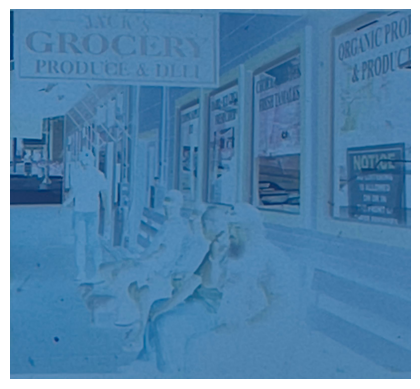

this image is abnormal but was predicted as normal


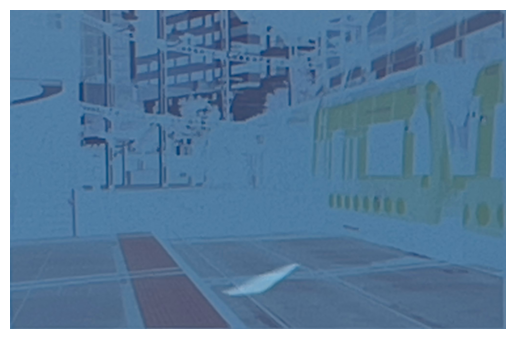

In [99]:
wrong_images, wrong_labels, wrong_preds = wrong_results(model,dataset)

for im, lb, pd in zip(wrong_images, wrong_labels, wrong_preds):
    print(f'this image is {'normal' if lb == 1 else 'abnormal'} but was predicted as {'normal' if pd >= 0.5 else 'abnormal'}')
    plt.imshow(im)
    plt.axis('off')
    plt.show()

